**Summary**

This is an interesting recruitment challenge for a company I found on the internet. There is a secret science lab with very busy scientists working around and the task is detecting all the actions that the scientists are performing in real-time to be sure that everything is going well.

The dataset consists of a collection of key points for a skeleton performing a single action over a series of frames. There are 5 different actions; including standing, walking, picking up, putting back, and raising a hand. Every single sample contains frame number, keypoint number, x, y, confidence_score`. 

Frame number shows how many frames a sample contains. 
A keypoint number is a number between 1 and 18, using MSCOCO's keypoint definition. 

`x` and `y` represent the coordinates of a specific keypoint. 
A confidence score is a number between 0 and 1, indicating how sure we can be that the current keypoint is present.


In [ ]:
import math
import numpy as np
import pandas as pd
import glob
import os
import pickle

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from keras.regularizers import *
from tensorflow.keras.optimizers import Adagrad, Adam, Adamax, Nadam, Optimizer, RMSprop, SGD, schedules 
from keras.models import Sequential, Model
from keras.layers import ConvLSTM2D, Conv3D, Conv2D, Conv1D, LSTM, Dense, TimeDistributed, Input, Dropout, Activation, Flatten, BatchNormalization, Masking
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import jaccard_score
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

from enum import Enum 
import random as rn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# view a few frames of one sample
f = '/content/drive/MyDrive/google_colab_skeleton/trainval/013_walking.csv'
df_sample = pd.read_csv(f, index_col=False, names = ['frame_number', 'keypoint_number', 'x', 'y', 'confidence_score'])
df_sample.head()

,frame_number,keypoint_number,x,y,confidence_score
0,0,2,536.956522,303.219512,0.813289
1,0,3,603.043478,266.341463,0.755957
2,0,6,499.782609,336.000000,0.757008
3,0,7,503.913043,467.121951,0.796871
4,0,8,503.913043,569.560976,0.848367


Data cleaning and preprocessing

When I inspect the dataset, I found some tricky points that need to be dealt with. Firstly, some key points are missing if they are not visible for that specific frame. I added a column that indicates whether the keypoint in a frame is visible or not (1/0). Then I added missing key points and filled them with zero. 

When I checked the number of frames at each sample, I also saw that it differs from sample to sample. I determined the sample with the maximum frame number in the dataset and padded all samples with zero to obtain fixed sequence lengths. 

The coordinates of the key points weren’t evenly distributed so they needed to be scaled. To shift and scale the points, the formula below is applied for the x and y coordinates of each keypoint in each sample to keep the coordinates in the open interval [0, 1) 

length of diagonal=sqrt((maxX-minX)*(maxX-minX) + (maxY-minY)*(maxY-minY)) 
normalized X = (originalX - minX)/(length of diagonal) 
normalized Y = (originalY - minY)/(length of diagonal)

In [ ]:
def add_missing_keypoints(frame):
    frame_number = int(frame.iloc[0,0])
    for i in range(18):
        if i >= len(frame) or frame.iloc[i,1] != i+1:
            frame = pd.DataFrame(np.insert(frame.values, i, values=[frame_number,0,0,0,0], axis=0))
    frame_copy = frame
    frame_copy.iloc[:,1][frame.iloc[:,1] != 0] = 1    
    return np.array(frame_copy)

In [ ]:
# Input: sample [frame, key_point, x, y, z]
# Output: frames [[frame, key_point, x, y, z]]

def slice_to_frames(sample):
    frames = set(sample.iloc[:,0])
    return [sample[sample.iloc[:,0] == i] for i in frames]

def flat_map(f, li):
    mapped = map(f, li)
    flattened = flatten_single_dim(mapped)
    yield from flattened

def flatten_single_dim(mapped):
    for item in mapped:
        for subitem in item:
            yield subitem

In [ ]:
def normalize(df):
    # Normalization operation involves a "shift and scale" operation
    # Normalization is applied to each sample seperately
    # We find the minimum and minimum values of X,Y from all the points and do a shift operation. This changes the origin to the lower left corner of the bounding box.
    # We calculate the length of the diagonal connecting (MinX,MinY) and (MaxX,MaxY) and use this value to do a scale operation.
    
    #length of diagonal=sqrt((maxX-minX)*(maxX-minX)+(maxY-minY)*(maxY-minY))
    #normalized X = (originalX - minX)/(length of diagonal) 
    #normalized Y = (originalY - minY)/(length of diagonal)
    
    max_x = max(df.iloc[:,2])
    max_y = max(df.iloc[:,3])

    min_x = min(df.iloc[:,2])
    min_y = min(df.iloc[:,3])

    length_of_diagonal = math.sqrt((max_x-min_x)**2 + (max_y-min_y)**2)
    
    df.iloc[:,2] = (df.iloc[:,2] - min_x)/ length_of_diagonal    #normalizing x coordinate column
    df.iloc[:,3] = (df.iloc[:,3] - min_y)/ length_of_diagonal    #normalizing y coordinate column
    
    return df



In [ ]:
def read(f):
    df = pd.read_csv(f, index_col=False)
    df = normalize(df)
    return df

In [ ]:
files = glob.glob("/Users/gonca/Desktop/skeleton_project/trainval/*.csv") 
csv_list = list(map(read, files)) # list of 540 sample lists of [frame, key_point, x, y, z]
frame_list = list(flat_map(slice_to_frames, csv_list)) # list of 37080 frame list of [frame, key_point, x, y, z]
padded_frames_list = list(map(add_missing_keypoints, frame_list)) # modified with inserted rows of missing keypoints

<ipython-input-28-a4f037a5c0c9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_copy.iloc[:,1][frame.iloc[:,1] != 0] = 1


In [ ]:
padded_frames_array = np.array(padded_frames_list)
raw_X = padded_frames_array[:,:,1:5]
np.save('/Users/gonca/Desktop/skeleton_project/08-09-2021/raw_X.npy', raw_X)
raw_X.shape

(37080, 18, 4)

In [ ]:
def categorize(string):
    string = string.split("_",2)[2]
    string = string.split(".",1)[0]
    return string
    
files = glob.glob("/Users/gonca/Desktop/skeleton_project/trainval/*.csv")

category_list = list(map(categorize, files))

In [ ]:
df = pd.DataFrame(category_list)
Y = np.array(pd.get_dummies(df))
np.save('/Users/gonca/Desktop/skeleton_project/08-09-2021/Y.npy', Y)
Y.shape

(540, 5)

In [ ]:
label_names = {0:'pick_up', 1:'put_back', 2:'raise_hand', 3:'standing', 4:'walking'}

In [ ]:
def replacing_missing_keypoints_and_padding(X, frame_numbers):

    padded_X=[]
    X_copy = X
    
    #for replacing the missing keypoints with the closest ones
    
    for frame_number in frame_numbers: # to define a sample
        sample = X_copy[0:frame_number,:,:]
        
        for frame in range(frame_number):     # to define frame indexes in a sample
            
            for keypoint in range(18):     # to define keypoint indexes in one frame
                if sample[frame,keypoint,0] == 0:  # check if there is a missing keypoint at that frame
                    
                    diff = 100000     #just as a big number
                    for f_new in range(frame_number): # a loop to find if that missing keypoint ever appears in an other frame of the sample
                        if sample[f_new,keypoint,0] == 1: 
                            if abs(frame-f_new) < diff:
                                sample[frame,keypoint,1:4] = sample[f_new,keypoint,1:4]
                                diff = abs(frame-f_new)
                            

        # for zero padding to equal the length of samples
        max_seq_number = 289
        for index in range(frame_number, max_seq_number):
            sample= np.insert(sample, index, values = np.zeros((18,4)), axis=0)
            
        
        padded_X.append(sample)    
        X_copy = X_copy[frame_number:,:,:]

    return np.array(padded_X)



In [ ]:
frame_numbers = []
for i in csv_list:
    frame_numbers.append(len(set(i.iloc[:,0])))

In [ ]:
padded_X = replacing_missing_keypoints_and_padding(raw_X, frame_numbers)
np.save('/Users/gonca/Desktop/skeleton_project/08-09-2021/padded_X.npy', padded_X)
padded_X.shape

(540, 289, 18, 4)


Feature extracting  	 		
Based on this article, I calculated the displacement of x and y coordinates of each keypoint at each time step and the distance of each keypoint from the center of gravity of the human pose skeleton. This calculation was done only for the visible key points and the rest are filled as zero for the invisible ones. In the end, I had two matrices with a dimension (18x2) for each frame of each sample.

After feature extraction, I shaped all data as a tensor with the shape of (540x289x6x3x8) where 540 is the number of the samples, 289 is the time steps, 6x3 is the key points and 8 is the channels. The 8 channels consist of:
the keypoint is visible or not
x coordinate
y coordinate
confidence score
displacement of x coordinate
displacement of y coordinate
distance from the center of gravity of x coordinate
distance from the center of gravity of y coordinate				
			

In [ ]:
def velocity(X):
    F_vel = []
    for s in range(len(X)):
        sample = X[s,:,:,:]
        prev_frame = sample[0,:,:]
        F_vel_sample = []
        
        for t in range(len(sample)):
            frame = sample[t,:,:]
            d = max(frame[:,2]) - min(frame[:,2]) + 0.000001     # the longest vertical distance (we use it for normaliation)

            Fvel_x = ((frame[:,1] - prev_frame[:,1])/d).reshape(18,1)
            Fvel_y = ((frame[:,2] - prev_frame[:,2])/d).reshape(18,1)

            Fvel_xy = np.concatenate((Fvel_x, Fvel_y), axis=1)
            F_vel_sample.append(Fvel_xy)
            prev_frame = sample[t,:,:]
        
        F_vel.append(F_vel_sample)
    return np.array(F_vel)

In [ ]:
F_VEL = velocity(padded_X) 
np.save('/Users/gonca/Desktop/skeleton_project/08-09-2021/F_VEL.npy', F_VEL) 
F_VEL.shape

(540, 289, 18, 2)

In [ ]:
def gravity_center(X):
    F_GRAVITY = []
    for s in range(len(X)):
        sample = X[s,:,:,:]
        F_GRAVITY_sample = []
    
        for t in range(len(sample)):
            frame = sample[t,:,:]
            CGx = sum(frame[:,1] * frame[:,0]) / (sum(frame[:,0]) + 0.000001)     # center of gravity value for x coordinates
            CGy = sum(frame[:,2] * frame[:,0]) / (sum(frame[:,0]) + 0.000001)     # center of gravity value for y coordinates
    
            d = max(frame[:,2]) - min(frame[:,2]) + 0.000001      # the longest vertical distance (we use it for normaliation)
    
            for_X = ((frame[:,1] - CGx)/d).reshape(18,1)      # center of gravity features of x coordinates,  
            for_Y = ((frame[:,2] - CGy)/d).reshape(18,1)     # center of gravity features of y coordinates, 
    
            for_xy = np.concatenate((for_X, for_Y), axis=1)
            F_GRAVITY_sample.append(for_xy)
        
        F_GRAVITY.append(F_GRAVITY_sample)                                                  
    return np.array(F_GRAVITY)

In [ ]:
F_GRAVITY = gravity_center(padded_X) 
np.save('/Users/gonca/Desktop/skeleton_project/08-09-2021/F_GRAVITY.npy', F_GRAVITY)  
F_GRAVITY.shape

(540, 289, 18, 2)

In [ ]:
X_8ch = np.concatenate((padded_X, F_GRAVITY, F_VEL), axis = 3)
X_8ch = X_8ch.reshape(540, 289, 6, 3, 8)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_8ch, Y, test_size = 0.20, shuffle = True)

In [ ]:
def model1():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(filters=filter_size, kernel_size=kernel_size_1, padding = 'same', input_shape=(289, 6, 3, 8), activation="sigmoid",  kernel_regularizer=l2(0.01))))
    model.add(TimeDistributed(BatchNormalization(-1)))
    model.add(TimeDistributed(Dropout(dropout)))
    model.add(TimeDistributed(Conv2D(filters=filter_size, kernel_size=kernel_size_2, padding = 'same', input_shape=(289, 6, 3, 8), activation="sigmoid",  kernel_regularizer=l2(0.01))))
    model.add(TimeDistributed(BatchNormalization(-1)))
    model.add(TimeDistributed(Dropout(dropout)))    
    model.add(TimeDistributed(Flatten()))
    
    model.add(Masking(mask_value=0.))
    model.add(LSTM(filter_size, dropout = dropout, recurrent_dropout=dropout, return_sequences=True, activation="sigmoid", kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout)) 
    
    model.add(Flatten())
    
    model.add(Dense(2*filter_size, activation="sigmoid",  kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dense_dropout))
    model.add(Dense(5, activation = "softmax"))

    return model

Model architecture
 
Using the form of the data as a sequence of rectangular prism shapes with 8 channels, I combined convolutional neural networks with LSTM (long short term memory). Batch normalization and dropout layers were used against the strong tendency of overfitting. Due to the limitations of the GPU, I experimented with a maximum of 256 neurons of CNN and LSTM layers and got the best results with 256 neurons.


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_28 (TimeDi  (None, 289, 6, 3, 256)   8448      
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 289, 6, 3, 256)   1024      
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 289, 6, 3, 256)   0         
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 289, 6, 3, 256)   590080    
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 289, 6, 3, 256)  

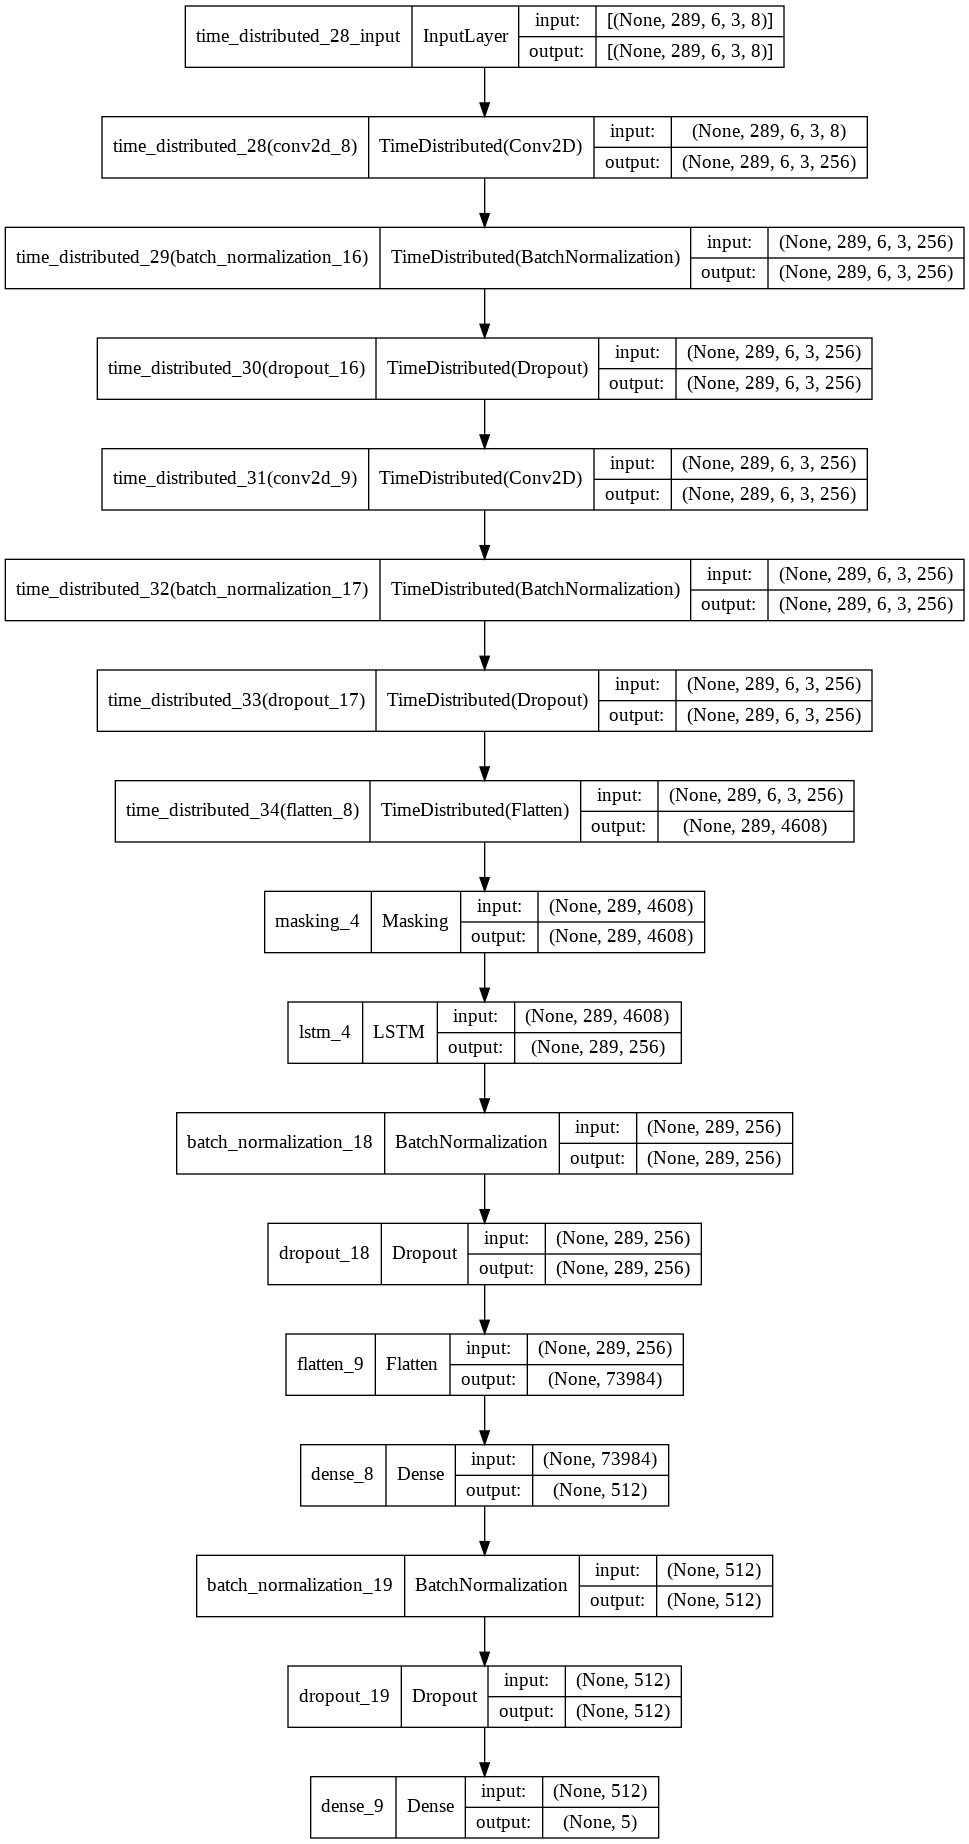

In [ ]:
dropout = 0.7
dense_dropout = 0.8
filter_size = 256
kernel_size_1 = (2, 2)
kernel_size_2 = (3, 3)
plot_model = model1()
plot_model.build(input_shape=(None, 289, 6, 3, 8)) 
plot_model.summary()
tf.keras.utils.plot_model(plot_model, to_file="plot_model.png", show_shapes=True)

In [ ]:
def tuning_train(X,Y, X_val, y_val):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
    
    opt  = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model = model1()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    history = model.fit(X, Y, epochs=epochs[0], batch_size = batch_size , shuffle=True, validation_data = (X_val, y_val))
    path = '/content/drive/MyDrive/google_colab_skeleton/Kfold/Fold_no'+str(fold_no)+'conv+lstm_filters'+str(filter_size)+'_dropout'+str(dropout)+'_densedrop'+str(dense_dropout)+'_8ch_lr_schedule'
    model.save(path)
    np.save(path+'.npy',history.history)
    model = tf.keras.models.load_model(path)
    history = model.fit(X, Y, epochs=epochs[1], batch_size = batch_size , shuffle=True, validation_data = (X_val, y_val))
    model.save(path)
    np.save(path+'.npy',history.history)
    model = tf.keras.models.load_model(path)
    history = model.fit(X, Y, epochs=epochs[2], batch_size = batch_size , shuffle=True, validation_data = (X_val, y_val))
    model.save(path)
    np.save(path+'.npy',history.history)


    # Generate generalization metrics
    model_score = model.evaluate(X_val, y_val, verbose=0)
    print(f'Model_score for fold {fold_no}: {model.metrics_names[0]} of { model_score[0]}; {model.metrics_names[1]} of { model_score[1]*100}%')

    # classification_report
    y_pred = model.predict(X_val)
    y_pred_argmax = np.argmax(y_pred, axis = 1)
    y_test_argmax = np.argmax(np.array(y_val), axis = 1)
    print(f'Model classification_report for fold {fold_no}: {classification_report(y_test_argmax, y_pred_argmax)}')

    return 

In [ ]:
def plot_acc(model_path):
    print(model_path)
    history=np.load(model_path+'.npy',allow_pickle='TRUE').item()
    
    # summarize history for accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(model_path+'acc.png')
    plt.show()
    

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(model_path+'loss.png')
    plt.show()
    

    return 

In [ ]:
def continue_training(X, Y, X_val, y_val, epochs):
    checkpoint_path = '/content/drive/MyDrive/google_colab_skeleton/Kfold/bestmodel'+str(fold_no)+'.ckpt'
    cp_callback = ModelCheckpoint(filepath = checkpoint_path, mode='max', monitor='val_accuracy', verbose=2, save_best_only=True)
    path = '/content/drive/MyDrive/google_colab_skeleton/Kfold/Fold_no'+str(fold_no)+'conv+lstm_filters'+str(filter_size)+'_dropout'+str(dropout)+'_densedrop'+str(dense_dropout)+'_8ch_lr_schedule'
    model = tf.keras.models.load_model(path)
    history = model.fit(X, Y, epochs=epochs, batch_size = batch_size , shuffle=True, validation_data = (X_val, y_val), callbacks = cp_callback)
    model.save(path)
    np.save(path+'.npy',history.history)

    # Generate generalization metrics
    model_score = model.evaluate(X_val, y_val, verbose=0)
    print(f'Model_score for fold {fold_no}: {model.metrics_names[0]} of { model_score[0]}; {model.metrics_names[1]} of { model_score[1]*100}%')

    # classification_report
    y_pred = model.predict(X_val)
    y_pred_argmax = np.argmax(y_pred, axis = 1)
    y_test_argmax = np.argmax(np.array(y_val), axis = 1)
    print(f'Model classification_report for fold {fold_no}: {classification_report(y_test_argmax, y_pred_argmax)}')

    # Best model generalization metrics
    model = tf.keras.models.load_model(checkpoint_path)
    model_score = model.evaluate(X_val, y_val, verbose=0)
    print(f'Best_Model_score for fold {fold_no}: {model.metrics_names[0]} of { model_score[0]}; {model.metrics_names[1]} of { model_score[1]*100}%')

    # Best model classification_report
    y_pred = model.predict(X_val)
    y_pred_argmax = np.argmax(y_pred, axis = 1)
    y_test_argmax = np.argmax(np.array(y_val), axis = 1)
    print(f'Best_Model classification_report for fold {fold_no}: {classification_report(y_test_argmax, y_pred_argmax)}')

    return 

In [ ]:
initial_learning_rate = 0.0001
dropout = 0.7
dense_dropout = 0.8
filter_size = 256
kernel_size_1 = (2, 2)
kernel_size_2 = (3, 3)
batch_size = 16
epochs = 125
tuning_train(X_train, y_train, X_val, y_val)
continue_training(X_train, y_train, X_val, y_val, epochs = 50)

Epoch 1/125
27/27 [==============================] - 49s 2s/step - loss: 33.4927 - accuracy: 0.2407 - val_loss: 31.2651 - val_accuracy: 0.2130
Epoch 2/125
27/27 [==============================] - 45s 2s/step - loss: 32.4523 - accuracy: 0.3449 - val_loss: 31.3426 - val_accuracy: 0.1667
Epoch 3/125
27/27 [==============================] - 45s 2s/step - loss: 32.0944 - accuracy: 0.4028 - val_loss: 31.3524 - val_accuracy: 0.1667
Epoch 4/125
27/27 [==============================] - 45s 2s/step - loss: 31.6885 - accuracy: 0.5023 - val_loss: 31.2860 - val_accuracy: 0.1667
Epoch 5/125
27/27 [==============================] - 45s 2s/step - loss: 31.2724 - accuracy: 0.5394 - val_loss: 31.1327 - val_accuracy: 0.1667
Epoch 6/125
27/27 [==============================] - 45s 2s/step - loss: 31.4448 - accuracy: 0.5139 - val_loss: 30.8758 - val_accuracy: 0.1667
Epoch 7/125
27/27 [==============================] - 45s 2s/step - loss: 31.2971 - accuracy: 0.5278 - val_loss: 30.5878 - val_accuracy: 0.3796

In [ ]:
initial_learning_rate = 0.0001
dropout = 0.7
dense_dropout = 0.8
filter_size = 256
kernel_size_1 = (2, 2)
kernel_size_2 = (3, 3)
batch_size = 16
epochs = 125
X = np.concatenate((X2, X3, X4, X5), axis = 0)
Y = np.concatenate((y2, y3, y4, y5), axis = 0)

continue_training(X, Y, X1, y1, epochs = 50)

Epoch 1/50
27/27 [==============================] - 84s 2s/step - loss: 9.8346 - accuracy: 0.7847 - val_loss: 9.3414 - val_accuracy: 0.8333

Epoch 00001: val_accuracy improved from -inf to 0.83333, saving model to /content/drive/MyDrive/google_colab_skeleton/Kfold/bestmodel1.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/google_colab_skeleton/Kfold/bestmodel1.ckpt/assets
Epoch 2/50
27/27 [==============================] - 47s 2s/step - loss: 9.3506 - accuracy: 0.7963 - val_loss: 9.1510 - val_accuracy: 0.8148

Epoch 00002: val_accuracy did not improve from 0.83333
Epoch 3/50
27/27 [==============================] - 47s 2s/step - loss: 9.2416 - accuracy: 0.7708 - val_loss: 8.9808 - val_accuracy: 0.8241

Epoch 00003: val_accuracy did not improve from 0.83333
Epoch 4/50
27/27 [==============================] - 47s 2s/step - loss: 9.1296 - accuracy: 0.7708 - val_loss: 8.8965 - val_accuracy: 0.8148

Epoch 00004: val_accuracy did not improve from 0.83333
Epoch 5/50
27/27 [====

/content/drive/MyDrive/google_colab_skeleton/Kfold/Fold_no1conv+lstm_filters256_dropout0.7_densedrop0.8_8ch_lr_schedule


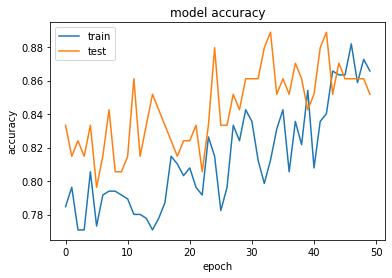

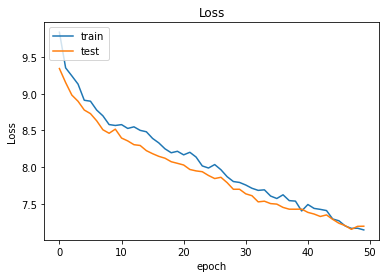

In [ ]:
model_path = '/content/drive/MyDrive/google_colab_skeleton/Kfold/Fold_no1conv+lstm_filters256_dropout0.7_densedrop0.8_8ch_lr_schedule'
model = tf.keras.models.load_model(model_path)
plot_acc(model_path)


In [ ]:
label_names = ['pick_up', 'put_back', 'raise_hand', 'standing', 'walking']

In [ ]:
cm = confusion_matrix(y_test_argmax, y_pred_argmax)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = label_names)
disp.plot() 

**Results**

When the confusion matrix is examined, it is seen that the model predicts some classes almost perfectly, while it has difficulties distinguishing two of them (picking up and putting back). At that point, I came up with creating a sub-model focused on distinguishing only these two labels. I experimented with several models and got the best performance with the data in a flattened form of extracted features as an 80-dimensional feature vector for each time series, and using LSTM architecture. 

By ensembling these two models, I achieved 90% accuracy in the test dataset.

For the notebook of sub model: https://colab.research.google.com/drive/1zDdfiTd7LDoPfDHgxWeLyyAsMgtdTvnw?usp=sharing

For the notebook of ensemble model and final results:
https://colab.research.google.com/drive/149a9a-cYccM0UMp3PtjCajkZsdj6c4OQ?usp=sharing